 # Hand-crafted features + XGBoost

Install and import required packages:


In [ ]:
! pip install pandas numpy tqdm  scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from datetime import timedelta, datetime
from sklearn.preprocessing import normalize

Configure notebook to use GPU:
1. Go to Runtime --> Change runtime type
2. Select GPU
3. Check if the device was properly selected

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

Device: 'cpu'


## Data
Dataset is based on [eCommerce behavior data from multi category store](https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store).  
To meet the limitations of the workshop environment we prepared a toy version of this dataset that can be downloaded from our GitHub repository.  
To access data:
1. Clone GitHub repository

In [ ]:
!git clone https://github.com/Synerise/predicting-user-behavior-workshop.git

2. Set the data directory to match the data folder location

In [5]:
DATA_DIR = "./predicting-user-behavior-workshop/data"

3. Check if you can load data properly

In [85]:
df = pd.read_csv(f"{DATA_DIR}/2019-Oct_small.csv")
target_brands = np.load(f"{DATA_DIR}/target_brands.npy", allow_pickle=True)
train_target = np.load(f"{DATA_DIR}/train_target.npy")
test_target = np.load(f"{DATA_DIR}/test_target.npy")
user_ids = np.load(f"{DATA_DIR}/user_ids.npy")
df

,event_time,brand,user_id
0,2019-10-01 00:02:14 UTC,samsung,543272936
1,2019-10-01 00:04:37 UTC,apple,551377651
2,2019-10-01 00:05:14 UTC,xiaomi,550121407
3,2019-10-01 00:06:02 UTC,xiaomi,514591159
4,2019-10-01 00:07:07 UTC,santeri,555332717
...,...,...,...
1669360,2019-10-31 23:55:21 UTC,puckator,514622109
1669361,2019-10-31 23:56:03 UTC,apple,512717356
1669362,2019-10-31 23:56:11 UTC,apple,533892594
1669363,2019-10-31 23:56:53 UTC,apple,533892594


## Task
We want to predict if a user will buy products of selected brands.
Here, we use the 20 most popular brands:

In [86]:
target_brands

array(['samsung', 'apple', 'xiaomi', 'huawei', 'oppo', 'lg', 'sony',
       'acer', 'cordiant', 'elenberg', 'bosch', 'artel', 'indesit',
       'lucente', 'philips', 'nokian', 'redmond', 'beko', 'haier',
       'vitek'], dtype=object)

### Number of events per brand for the top 20 brands

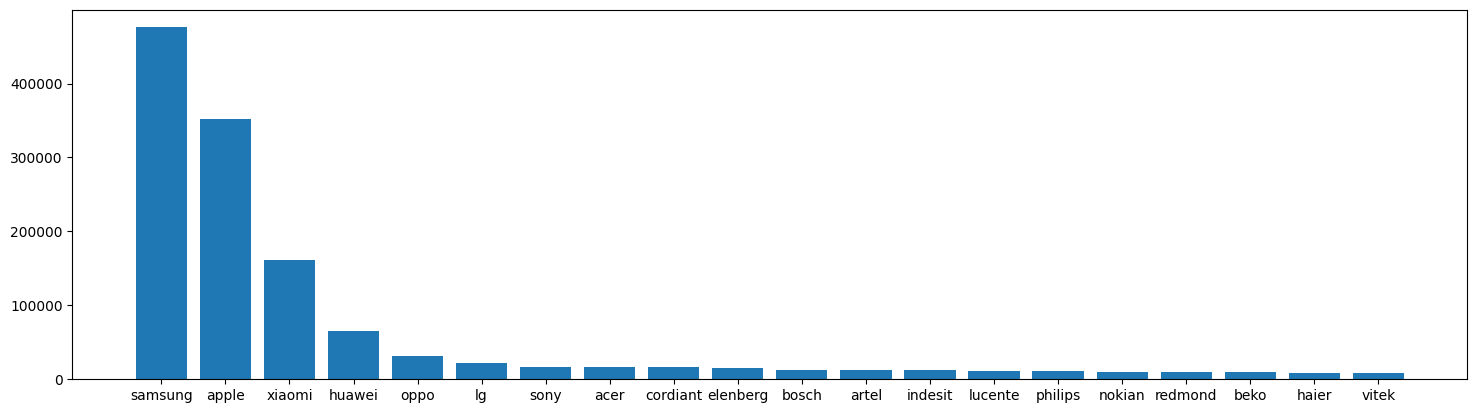

In [87]:
plt.figure().set_figwidth(18)
plt.bar(target_brands, df['brand'].value_counts()[:20].to_numpy())
plt.show()

### Other applications
When working with real-life data, this task can be easily modified to better fit business requierments. For example:

* selecting an arbitrary subset of brands for the targeted campaigns
* predicting product categories user will buy
* predicting offers a user will be interested in
* predicting what kind of subscription plan is user willing to choose




## Target
In this workshop, we use all events from October 2019 to create the model's input representing user interactions from this period. To create training targets (ground truth labels), we use the first week of November.

**For each of the selected brands, we check if a user bought any product of this brand in the first week of November.**

In [88]:
train_target.shape

(481458, 20)

In [98]:
print(f"User id: {user_ids[1380]}")
print(f"Target: {train_target[1380]}")
print(f"Brands in target: {target_brands[np.where(train_target[1380] == 1)]}")

User id: 512374551
Target: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Brands in target: ['samsung' 'apple']


Next, we use the following 7 days — the second week of November, to measure model performance.

In [47]:
test_target.shape

(481458, 20)

To create the train and the test sets, we use the same set of users but two consecutive time windows — the first week of November for training and the second for testing. This mimics a real-life setting where we predict the future actions of our users based on historical data.

## Hand-crafted features

To create a user representation that we can use as a model input, we must aggregate information from user history and represent it in a numerical form.  

The presented method is based on features that are hand-picked and tested by a data scientist contrary to learned representations, e.g. embeddings.

**Example of hand-crafted features in e-commerce**:

* number of products bought in the last day, week or month
* products bought/viewed/added-to-cart in the given category, brand
* average cart value

**Example of hand-crafted features in banking**:

* number of transactions per day
* number of transactions per category
* average transaction value
* account type
* special offers

**Example of hand-crafted features in telecom**:

* type of subscription
* internet usage
* number of phone calls per day/week/month

These are only a few examples of such features. In practice, feature creation stems from domain knowledge and information available in data. What should be considered are:
* **available types of events** (e.g., page view, transaction, subscription, product buy, add-to-cart)  
* **time windows** relevant for given data characteristics and domain requirements (in the grocery store app we may consider last days, but in ... last hours may be more relevant)
* event **object metadata** (e.g., product brand, transaction value, offer popularity, page category)
* **user metadata** (e.g., age, location, account type)

### Example features
In the toy dataset, we have only information about user, brand, and time. What we can consider when creating a user feature vector:

* total number of events per user
* number of events per brand (or selected subset of brands)
* number of events in selected time windows
* number of events per brand in selected time windows

In the following code, we want to consider for each user:

* total number of events
* number of events per brand for 30 most popular brands

In [ ]:
#@title Task: select top 30 brands that will be used to create features
BRANDS = ...

In [90]:
#@title Solution
BRANDS = df["brand"].value_counts()[:30].index
BRANDS


Index(['samsung', 'apple', 'xiaomi', 'huawei', 'oppo', 'lg', 'sony', 'acer',
       'cordiant', 'elenberg', 'bosch', 'artel', 'indesit', 'lucente',
       'philips', 'nokian', 'redmond', 'beko', 'haier', 'vitek', 'tefal',
       'lenovo', 'triangle', 'hp', 'nokia', 'starline', 'jbl', 'dauscher',
       'polaris', 'vivo'],
      dtype='object')

To create features we consider events from October.  
We group events by users and for each user, we check:
* number of events in each of the selected 30 brands  
* total number of events


In [93]:
def compute_features(events, brands):
    features = np.zeros(len(brands))
    # number of events per brand in brands
    for val in events["brand"].unique():
        features[np.where(brands == val)] += np.sum(
            events["brand"] == val
        )
      # total number of events
    features = np.hstack([events.shape[0], features])
    return features

In [94]:
user_events = df.groupby("user_id")
feature_size = len(BRANDS) + 1
features = np.zeros((len(user_ids), feature_size))
for user, events in tqdm(user_events):
    user_features = compute_features(events, BRANDS)
    features[np.where(user_ids == user), :] = user_features

100%|██████████| 481458/481458 [10:29<00:00, 764.62it/s]


In [95]:
features.shape

(481458, 31)

In [100]:
print(f"User id: {user_ids[1380]}")
print(f"Features: {features[1380]}")

User id: 512374551
Features: [8. 6. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


## Training XGBoost model

First, we set model parameters:  
**n_estimators** — number of trees  
**max_depth** —  maximum depth of a tree  
**learning_rate** — shrinkage factor used in model updates to prevent overfitting  
**objective** — foss function; here we use loss function for binary classification task  

In [103]:
N_ESTIMATORS = 10
MAX_DEPTH = 4
LEARNING_RATE = 0.1
OBJECTIVE = 'binary:logistic'

## Imbalanced data
Positive examples are rare in the presented dataset. This means that the number of products bought for the selected brands is low relative to the number of users.

**Total number of users**:

In [104]:
user_ids.size

481458

### Number of users that bought products of a given brands in train target

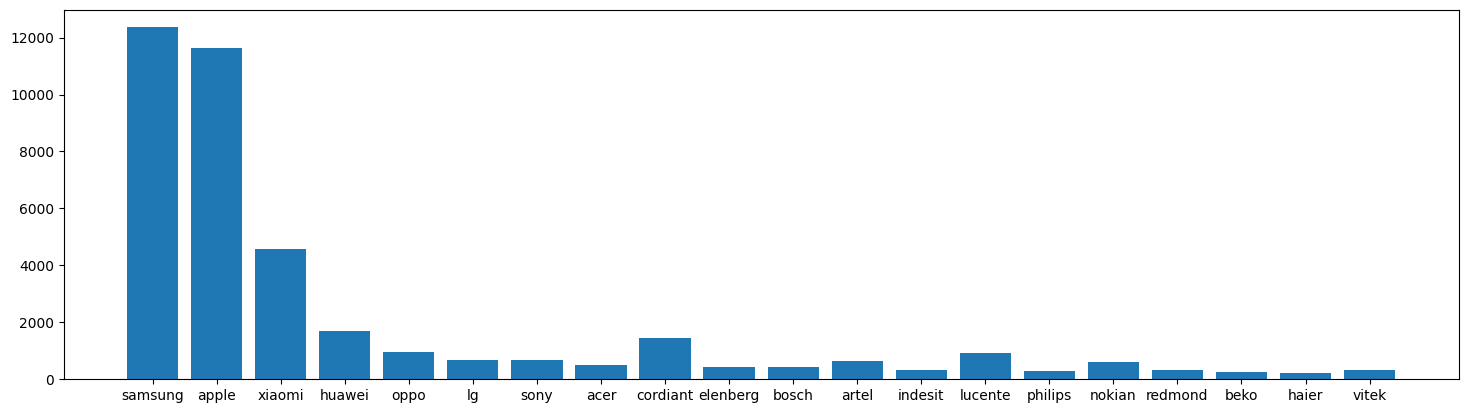

In [80]:
plt.figure().set_figwidth(18)
plt.bar(target_brands, np.sum(train_target, axis=0))
plt.show()

### Number of users that bought products of a given brands in test target

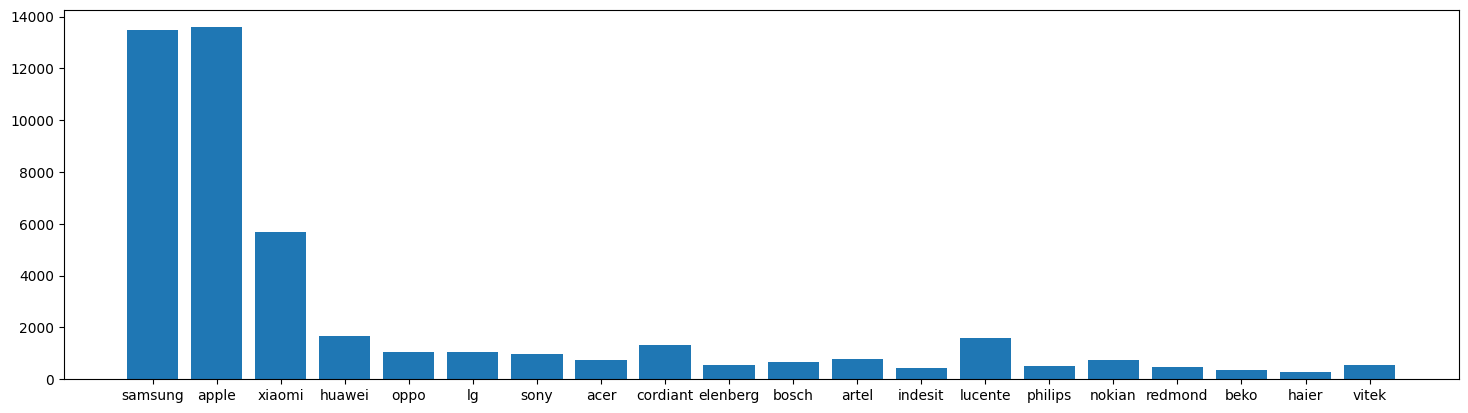

In [84]:
plt.figure().set_figwidth(18)
plt.bar(target_brands, np.sum(test_target, axis=0))
plt.show()

### Working with imbalanced data
One way to handle imbalanced data working with XGBoost library is to set `scale_pos_weight`. It is a multiplier of a loss function on positive training examples.

In [105]:
SCALE_POS_WEIGHT = 100


## Model
Next, we create an XGBoost model for the classification task and fit it on our data. Generated `features` are what we input to the model and `train_target` is what the model predicts.

In [106]:
from xgboost import XGBClassifier
from xgboost import XGBClassifier
# create model instance
bst = XGBClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, learning_rate=LEARNING_RATE, scale_pos_weight=SCALE_POS_WEIGHT, n_jobs=10, objective=OBJECTIVE)
# fit model
bst.fit(features, train_target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=10,
              num_parallel_tree=None, random_state=None, ...)

Finally, we compute the AUC score on the test target:


In [107]:
from sklearn.metrics import roc_auc_score
# make predictions
preds = bst.predict(features)
# compute test score
test_score = roc_auc_score(test_target, preds)
test_score

0.5957775887974723

## EXERCISE

(Advanced) Compute features for different time windows.


In [ ]:
#@title Solution
def compute_timewindows_features(events, num_days, max_date, brands):
    features = np.array([])
    events = events.sort_values("event_time")
    for days in num_days:
        start_date = max_date - timedelta(days=days)
        idx = np.searchsorted(events["event_time"], start_date)
        features_per_days = np.zeros(len(brands))
        values = events["brand"].to_numpy(na_value="nan")[idx:]
        for val in np.unique(values):
            features_per_days[np.where(brands == val)] += np.sum(
                values == val
            )
        features_per_days = np.hstack([len(values), features_per_days])
        features = np.hstack([features, features_per_days])
    return features

TIME_WINDOWS = [1, 7, 30]

df["event_time"] = pd.to_datetime(df.event_time)
user_events = df.groupby("user_id")
max_date = df["event_time"].max()
feature_size = len(TIME_WINDOWS) * len(BRANDS) + len(TIME_WINDOWS)
features = np.zeros((len(user_ids), feature_size))
for user, events in tqdm(user_events):
    user_features = compute_timewindows_features(events, TIME_WINDOWS, max_date, BRANDS)
    features[np.where(user_ids == user), :] = user_features